In [1]:
import math
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from sklearn import datasets
from sklearn.cluster import DBSCAN

from scipy.stats import norm


## Точечные аномалии
### Гистограммы

Possible outlier at 25.98641055431022.
Possible outlier at 30.0.


<ipython-input-28-94103b2f4b03>:11: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  colors = np.empty_like(counts, dtype=np.str)


<BarContainer object of 13 artists>

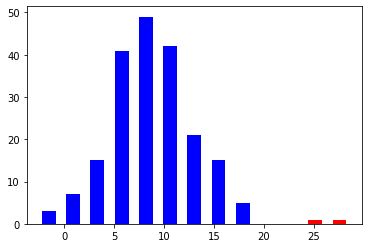

In [28]:
np.random.seed(28)
size = 200
normal_dist = np.random.normal(loc=10, scale=4, size=size)
anomaly = 30
bins = int(normal_dist.max() - normal_dist.min())//2

normal_dist[size//3] = anomaly
counts, coordinates = np.histogram(normal_dist, bins)

anomaly_idxs = np.where( counts==1 )[0]
colors = np.empty_like(counts, dtype=np.str)
colors[:]='blue'
colors[anomaly_idxs] = 'red'
for anomaly_idx in anomaly_idxs:
    anomaly_min = coordinates[anomaly_idx]
    if anomaly_idx + 1 < coordinates.shape[0]:
        anomaly_max = coordinates[anomaly_idx + 1]
    else:
        anomaly_max = np.inf

    anomaly_candidates = normal_dist[np.where(np.logical_and(normal_dist>=anomaly_min, normal_dist<= anomaly_max))]
    for anomaly_candidate in anomaly_candidates:
        print(f"Possible outlier at {anomaly_candidate}.")

plt.bar(coordinates[:-1], counts, width=normal_dist.max()/bins * 0.6, color=colors)


### Метод максимального правдоподобия

The max LL for sd 0.50 is -7708.21
The max LL for sd 1.00 is -2099.55
The max LL for sd 1.50 is -1116.33
The max LL for sd 2.00 is -801.36
The max LL for sd 2.50 is -673.57
The max LL for sd 3.00 is -616.37
The max LL for sd 3.50 is -590.73
The max LL for sd 4.00 is -580.78
The max LL for sd 4.50 is -579.21
The max LL for sd 5.00 is -582.31
The max LL for sd 5.50 is -588.07
The max LL for sd 6.00 is -595.36
The max LL for sd 6.50 is -603.49
The max LL for sd 7.00 is -612.07
The max LL for sd 7.50 is -620.83
The max LL for sd 8.00 is -629.61
The max LL for sd 8.50 is -638.32
The max LL for sd 9.00 is -646.88
The max LL for sd 9.50 is -655.27


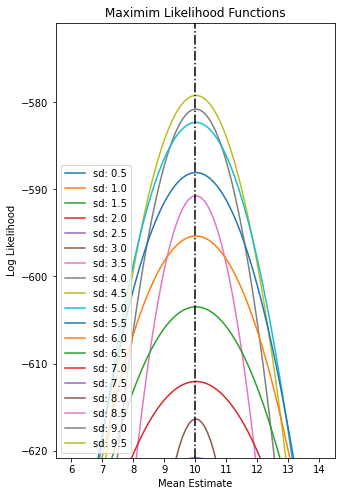

In [33]:
def calculate_ll(x):
    plt.figure(figsize=(5,8))
    plt.title("Maximim Likelihood Functions")
    plt.xlabel("Mean Estimate")
    plt.ylabel("Log Likelihood")
    mean_set = np.arange(0, 16, 0.1)
    sd_set = np.arange(0.5, 10, 0.5)
    max_sd_global = 0
    max_ll_global = -np.inf
    max_mean_global = 0
    max_ll_history = []
    for sd in sd_set:
        max_ll = -np.inf
        max_mean = 0
        ll_array = []

        for mean in mean_set:
            ll_sum = 0
            for k in x:
                ll_sum += norm.logpdf(k, loc=mean, scale=sd) # The LL function
            ll_array.append(ll_sum)

            if max_ll is None or max_ll < ll_sum:
                max_ll = ll_sum
                max_mean = mean
        max_ll_history.append(max_ll)
        plt.plot(mean_set, ll_array, label=f"sd: {sd}")

        if max_ll_global < max_ll:
            max_sd_global = sd
            max_mean_global = max_mean
            max_ll_global = max_ll

        print("The max LL for sd %.2f is %.2f" % (sd, max_ll))

    lower_point = np.median(max_ll_history)
    upper_point = np.max(max_ll_history)
    upper_point += (upper_point - lower_point)*0.2

    plt.ylim(lower_point, upper_point)
    plt.xlim(max_mean_global-max_sd_global, max_mean_global + max_sd_global)
    plt.axvline(x=max_mean_global, color='black', ls='-.')
    plt.legend(loc='lower left')
    return max_sd_global, max_mean_global

best_sd, best_mean = calculate_ll(normal_dist)

In [36]:
for x in normal_dist:
    score = norm.pdf(x, loc=best_sd, scale=best_mean)
    if score < 0.005:
        print(f"Outlier at {x:.4f}. Score is {score:.4f}")


Outlier at 30.0000. Score is 0.0015
Outlier at 25.9864. Score is 0.0040


## Коллективные аномалии
### Сгенерированный датасет

In [619]:
n_samples = 500
np.random.seed(0)
dataset = datasets.make_blobs(n_samples=n_samples, random_state=10, centers=2, cluster_std=1)[0]

outlier1 = datasets.make_blobs(n_samples=10, random_state=25, centers=1, cluster_std=0.2)[0]
outlier2 = datasets.make_blobs(n_samples=10, random_state=30, centers=1, cluster_std=0.2)[0]
dataset = np.vstack([dataset, outlier1, outlier2])

colors = np.zeros(shape=(dataset.shape[0],))

colors[500:520] = 1


def plot(d, colors=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1, 9)
    ax.set_ylim(-13, 8)
    if colors is None:
        ax.scatter(d[:, 0], d[:, 1])
    else:
        ax.scatter(d[:, 0], d[:, 1], cmap='Set1', c=colors)

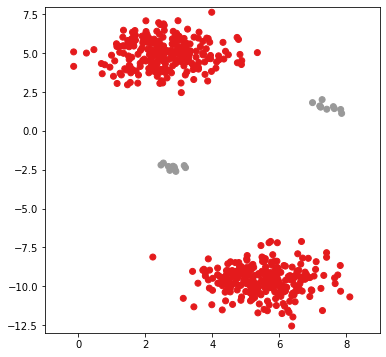

In [620]:
plot(dataset, colors)

### Метод вложенных циклов

In [40]:
def euclidean(x, y):
    return np.sqrt(np.sum((x - y) ** 2))


def inner_cycle(dataset, r, alpha):
    A = set()
    for x in dataset:
        count = 0
        for y in dataset:
            if x is not y and euclidean(x, y) <= r:
                count += 1
                if count >= math.ceil(alpha * dataset.shape[0]):
                    A.add(tuple(x))
                    break
    return np.array(list(A))

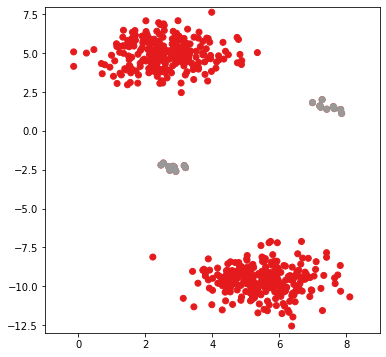

In [139]:
answer = inner_cycle(dataset, 12, 0.7)
answer = np.vstack([dataset, answer])
anomaly_colors = np.zeros(shape=(answer.shape[0]))
anomaly_colors[dataset.shape[0]:] = 1

plot(answer, anomaly_colors)


### Кластеризация DBSCAN

In [176]:
def run_clustering(eps=0.5, min_samples=5):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    res = model.fit_predict(dataset)
    plot(dataset, res)

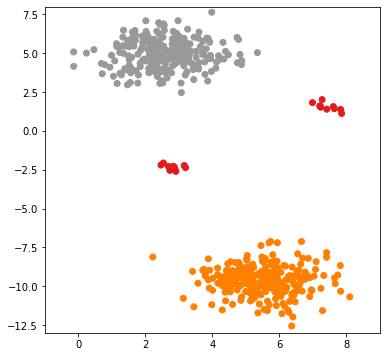

In [184]:
run_clustering(2, 100)


## Аномалии во временных рядах
### Алгоритм HOT-SAX

In [38]:
def z_normalize(series, znorm_threshold):
    sd = np.std(series)
    if sd < znorm_threshold:
        return series
    mean = np.mean(series)
    return (series - mean) / sd


def get_breakpoins(size):
    return {2: np.array([-np.inf, 0.00]),
            3: np.array([-np.inf, -0.4307273, 0.4307273]),
            4: np.array([-np.inf, -0.6744898, 0, 0.6744898]),
            5: np.array([-np.inf, -0.841621233572914, -0.2533471031358,
                         0.2533471031358, 0.841621233572914]),
            6: np.array([-np.inf, -0.967421566101701, -0.430727299295457, 0,
                         0.430727299295457, 0.967421566101701]),
            7: np.array([-np.inf, -1.06757052387814, -0.565948821932863,
                         -0.180012369792705, 0.180012369792705, 0.565948821932863,
                         1.06757052387814]),
            8: np.array([-np.inf, -1.15034938037601, -0.674489750196082,
                         -0.318639363964375, 0, 0.318639363964375,
                         0.674489750196082, 1.15034938037601]),
            9: np.array([-np.inf, -1.22064034884735, -0.764709673786387,
                         -0.430727299295457, -0.139710298881862, 0.139710298881862,
                         0.430727299295457, 0.764709673786387, 1.22064034884735]),
            10: np.array([-np.inf, -1.2815515655446, -0.841621233572914,
                          -0.524400512708041, -0.2533471031358, 0, 0.2533471031358,
                          0.524400512708041, 0.841621233572914, 1.2815515655446])}[size]



def paa(series, paa_segment_size):
    series = np.array(series)
    series_len = series.shape[0]

    res = np.zeros((paa_segment_size,))

    # Check if we can evenly divide the series.
    if series_len % paa_segment_size == 0:
        inc = series_len // paa_segment_size

        for i in range(0, series_len):
            idx = i // inc
            res[idx] += series[i]
        res /= inc
    # Process otherwise.
    else:
        for i in range(0, paa_segment_size * series_len):
            idx = i // series_len
            pos = i // paa_segment_size
            res[idx] += series[pos]
        res /= series_len

    return res


def paa_to_sax(series, alphabet_size):
    series = np.array(series)
    cuts = get_breakpoins(alphabet_size)
    sax = list()

    for i in range(series.shape[0]):
        num = series[i]
        idx = np.searchsorted(cuts, num) - 1
        sax.append(chr(97 + idx))
    return ''.join(sax)


def sax_via_window(series, win_size, paa_size, alphabet_size, znorm_threshold):
    # Convert to numpy array.
    series = np.array(series)
    sax = defaultdict(list)

    for i in range(series.shape[0] - win_size + 1):
        sub_section = series[i: i + win_size]
        zn = z_normalize(sub_section, znorm_threshold)
        paa_rep = paa(zn, paa_size)
        curr_word = paa_to_sax(paa_rep, alphabet_size)

        sax[curr_word].append(i)
    return sax


def find_discords_hotsax(series, win_size=100, num_discords=2, alphabet_size=3,
                          word_size=3, znorm_threshold=0.1):
    """HOT-SAX-driven discords discovery."""
    discords = list()

    visited_positions = set()

    # Z-normalized versions for every subsequence.
    print("Normalizing")
    znorms = np.array([z_normalize(series[pos: pos + win_size], znorm_threshold) for pos in range(len(series) - win_size + 1)])

    # SAX words for every subsequence.
    print("Looking for words")
    sax_words = sax_via_window(series, win_size=win_size, paa_size=word_size, alphabet_size=alphabet_size, znorm_threshold=0.1)

    word_frequency = [(k, len(v)) for k, v in sax_words.items()]
    word_frequency = sorted(word_frequency, key=lambda k: k[1])

    print("Looking for discords")
    while len(discords) < num_discords:

        best_discord = find_best_discord_hotsax(series, win_size, visited_positions, sax_words, word_frequency, znorms)

        if -1 == best_discord[0]:
            break

        discords.append(best_discord)

        mark_start = max(0, best_discord[0] - win_size + 1)
        mark_end = best_discord[0] + win_size

        for i in range(mark_start, mark_end):
            visited_positions.add(i)

    return discords


def find_best_discord_hotsax(series, win_size, visited_positions, sax_words, word_frequency, znorms):
    best_so_far_position = -1
    best_so_far_distance = 0.

    for entry in word_frequency:
        curr_word = entry[0]
        occurrences = sax_words[curr_word]

        for curr_pos in occurrences:
            # Already visited
            if curr_pos in visited_positions:
                continue

            nn_dist = np.inf
            complete_search = True

            cur_seq = znorms[curr_pos]
            # Avoid overlapping subsequence
            mark_start = curr_pos - win_size + 1
            mark_end = curr_pos + win_size
            visit_set = set(range(mark_start, mark_end))

            for next_pos in occurrences:
                # Avoid overlapping subsequence
                if next_pos in visit_set:
                    continue
                else:
                    visit_set.add(next_pos)

                dist = euclidean(cur_seq, znorms[next_pos])

                if dist < nn_dist:
                    nn_dist = dist
                if dist < best_so_far_distance:
                    complete_search = False
                    break

            if complete_search:
                visit_array = [i for i in range(0, (len(series) - win_size + 1)) if not (i in visit_set)]
                it_order = np.random.permutation(visit_array)
                for c_pos in it_order:
                    dist = euclidean(cur_seq, znorms[c_pos])
                    if dist < nn_dist:
                        nn_dist = dist
                    if dist < best_so_far_distance:
                        nn_dist = dist
                        break

            if (nn_dist > best_so_far_distance) and (nn_dist < np.inf):
                best_so_far_distance = nn_dist
                best_so_far_position = curr_pos

    return best_so_far_position, best_so_far_distance

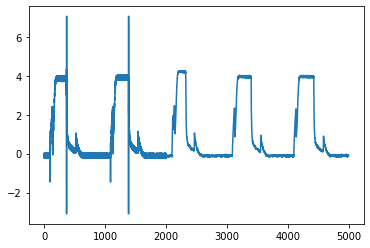

In [47]:
import pandas as pd

df = pd.read_csv('TEK17.CSV', header=None)
timeseries = df.to_numpy()[:, 0]

plt.plot(timeseries)

Normalizing
Looking for words
Looking for discords


[(2101, 4.004996878900157)]

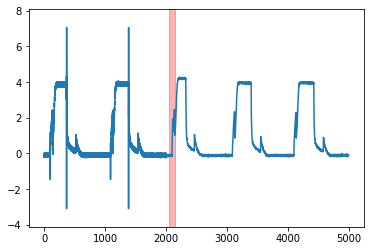

In [48]:
width = 100
discords2 = find_discords_hotsax(timeseries, num_discords=1, alphabet_size=4, word_size=4, win_size=width, znorm_threshold=2)
ax = plt.subplot()
ax.plot(timeseries)
diff = timeseries.max() - timeseries.min()
ax.set_ylim(timeseries.min() - diff * 0.1, timeseries.max() + diff * 0.1)
for d in discords2:
    ax.add_patch(Rectangle((d[0] - width/2, timeseries.min() - diff * 0.1), width, diff * 1.2, fill=True, alpha=0.3, color='red'))

discords2